# Tutorial 5: Training a UNet

This tutorial is the second part of the two part tutorial series of how to use *simulated* plankton image datasets to train a deep learning model, to segment and classify plankton species. In the first part ([check here](https://github.com/softmatterlab/Deep-learning-in-plankton-ecology/blob/main/segmentation-tutorials/4-simulating_planktons.ipynb)), we have seen how to simulate plankton species, *Noctiuluca scintillans* and *Dunaliella tertiolecta*, and how to create a dataset of simulated images. In this tutorial, we will see how to train a UNet model to segment the simulated images.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/softmatterlab/Deep-learning-in-plankton-ecology/blob/main/segmentation-tutorials/5-training_UNet_segmentation.ipynb)

Specifically, this tutorial will cover the following topics:
* Creating a U-Net model
* Training the model on the simulated dataset
* Predicting the trained model on experimental images
* Visualizing the results


**NOTE**:
- If you're running this notebook on your local machine, please comment the code in the cell below

In [ ]:
!git clone https://github.com/softmatterlab/Deep-learning-in-plankton-ecology.git
%cd Deep-learning-in-plankton-ecology/segmentation-tutorials

## 1. Setup
Imports the required python packages needed to run this tutorial.

In [1]:
import sys

sys.path.append("..")

import numpy as np
from PIL import Image
from tqdm import tqdm
import cv2
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import matplotlib.pyplot as plt

import deeptrack as dt
from utils import UNet

cpu


/Users/xbacss/Documents/GitHub/DeepTrack2/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/Users/xbacss/Documents/GitHub/DeepTrack2/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
2023-09-18 13:22:15.883376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Load the simulated dataset
Here we import the code we have written in the first part ([check here](https://github.com/softmatterlab/Deep-learning-in-plankton-ecology/blob/main/segmentation-tutorials/4-simulating_planktons.ipynb)) of this tutorial series, to load the simulated dataset.

### 2.1. Generate images
We will use the `generate_images` function to prepare the simulated images and the ground truth masks for both the species.

In [2]:
# Define the final image size
IMAGE_SIZE = 256

# Define the optical system
optics = dt.Fluorescence(
    wavelength=500e-9,
    NA=1.2,
    resolution=1e-6,
    magnification=12,
    refractive_index_medium=1.33,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
)

# Define point particles that represent plankton species, Dunaliella tertiolecta
point_particles = dt.Sphere(
    position=lambda: np.random.uniform(0, IMAGE_SIZE, 2),
    radius=lambda: np.random.uniform(0.2e-6, 0.4e-6),
    intensity=lambda: np.random.uniform(1, 1.5),
    z=lambda: np.random.uniform(-5, 5),
)

# Define inner spheres that represent plankton species, Noctiluca scintillans
inner_spheres = dt.Sphere(
    position=lambda: np.random.uniform(0, IMAGE_SIZE, 2),
    radius=lambda: np.random.uniform(2e-6, 5e-6),
    intensity=lambda: -1 * np.random.uniform(0.8, 1.2),
)

# Define outer spheres that represent plankton species, Noctiluca scintillans
outer_spheres = dt.Sphere(
    position=inner_spheres.position,
    radius=inner_spheres.radius * 1.1,
    intensity=inner_spheres.intensity * -1,
)

# Combine the inner and outer spheres to create a single plankton species
combined_spheres = inner_spheres >> outer_spheres

# Define the number of Dunaliealla and Noctiluca in the image
point_particles_in_image = lambda: np.random.randint(20, 30)
spheres_in_image = lambda: np.random.randint(1, 3)

# Define the transformations applied to the point particles (Dunaliella tertiolecta)
point_cells = (
    (point_particles ^ point_particles_in_image)
    >> dt.Pad(px=(5, 5, 5, 5))
    >> dt.ElasticTransformation(alpha=50, sigma=8, order=1)
    >> dt.CropTight()
    >> dt.Poisson(snr=3)
    # You can add more transformations here
)

# Define the transformations applied to the spheres (Noctiluca scintillans)
spherical_cells = (
    (combined_spheres ^ spheres_in_image)
    >> dt.Pad(px=(5, 5, 5, 5))
    >> dt.ElasticTransformation(alpha=50, sigma=8, order=1)
    >> dt.CropTight()
    >> dt.Poisson(snr=3)
    # You can add more transformations here
)

# Normalize the images: For noise approriate level of noise in the next step
normalization = dt.NormalizeMinMax(
    min=lambda: np.random.rand() * 0.4,
    max=lambda min: min + 0.1 + np.random.rand() * 0.5,
)

# Add Poisson noise to the image
noise = dt.Poisson(snr=lambda: np.random.uniform(30, 40), background=normalization.min)

# Define the final sample
sample = optics(point_cells & spherical_cells) >> normalization >> noise

# Write a function to extract massk for Noctiluca scintillans
def transf():
    def inner(scatter_mask):

        mask = scatter_mask.sum(-1) != 0
        output = np.zeros((*scatter_mask.shape[:2], 1))

        output[mask] = 1

        return output

    return inner

# Write a function to extract massk for Dunaliella tertiolecta
def transf2(circle_radius=3):
    def inner(image):
        X, Y = np.mgrid[: 2 * circle_radius, : 2 * circle_radius]
        CIRCLE = (X - circle_radius + 0.5) ** 2 + (
            Y - circle_radius + 0.5
        ) ** 2 <= circle_radius**2
        CIRCLE = CIRCLE[..., None]
        return CIRCLE

    return inner

# Apply the functions to the sample
masks1 = spherical_cells >> dt.SampleToMasks(
    transf, output_region=optics.output_region, merge_method="or", number_of_masks=1
)

masks2 = point_cells >> dt.SampleToMasks(
    transf2, output_region=optics.output_region, merge_method="or", number_of_masks=1
)

# Combine the sample and the masks
image_and_labels = sample & masks1 & masks2

def generate_images():
    return image_and_labels

Plot sample images and masks

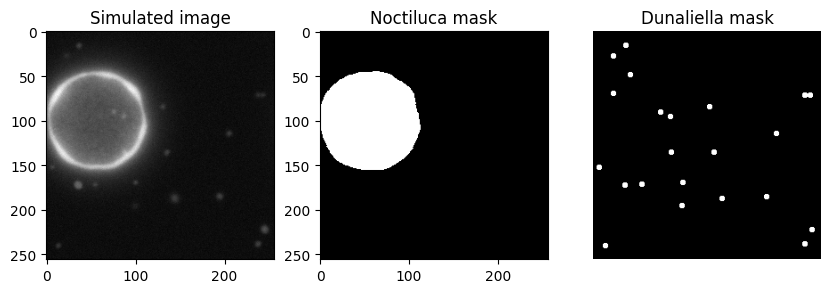

In [3]:
def generate_images():
    return image_and_labels


# Plot some example simulated images and masks
im, m1, m2 = generate_images().update()()

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Simulated image")
plt.imshow(im, cmap="gray")
plt.subplot(1, 3, 2)
plt.title("Noctiluca mask")
plt.imshow(m1[..., 0], cmap="gray")
plt.subplot(1, 3, 3)
plt.title("Dunaliella mask")
plt.imshow(m2[..., 0], cmap="gray")
plt.axis("off")
plt.show()

### 2.2. Create helper functions 
Here, we write a helper function `transform_masks` to modify the masks shown above into a proper format for training.

The reasoning behind generating two segmentation masks for different species is as follows: We want the neural network (UNet) to give us two images, where pixels in each image predict the probability of that pixel belonging to the respective species. This can be seen in the above example image, where the mask of Noctiluca has pixels values as 1 in the region where the Noctiluca is present, and 0 elsewhere. Similarly, the mask of Dunaliella has pixel values as 1 in the region where the Dunaliella is present, and 0 elsewhere.

In order to train a network to understand this, we need to provide it with a single image as output, where different pixel values will represent different things. Here, a 0 pixel value represents background, 1 represents Noctiluca, and 2 represents Dunaliella. This is what the `transform_masks` function does.

In [4]:
def transform_masks(m1, m2):
    combined_mask = m1 + m2 * 2
    combined_mask[combined_mask == 3] = 1  # When overlapping, only keep the first mask
    return combined_mask

### 2.3. Generate training data
You can control whether you want to train a new model or load a pre-trained model by setting the parameter `TRAIN` to `True` or `False` respectively.

When the parameter is set to False, we will not be generating the training and validation data.

In [5]:
# Set TRAIN to True to generate new data for trianing the network
TRAIN = False

In [6]:
if TRAIN:

    DATA_LENGTH = 1024

    train_images = []
    train_labels = []
    for i in tqdm(range(DATA_LENGTH), desc="Generating training data"):
        img, mask1, mask2 = generate_images().update()()
        img = np.array(img)
        mask1 = np.array(mask1)
        mask2 = np.array(mask2)
        train_images.append(img)
        train_labels.append(transform_masks(mask1, mask2))  # already summed
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)

In [7]:
if TRAIN:

    VAL_DATA_LENGTH = 256

    val_images = []
    val_labels = []
    for i in tqdm(range(VAL_DATA_LENGTH), desc="Generating validation data"):
        img, mask1, mask2 = generate_images().update()()
        img = np.array(img)
        mask1 = np.array(mask1)
        mask2 = np.array(mask2)
        val_images.append(img)
        val_labels.append(transform_masks(mask1, mask2))  # already summed
    val_images = np.array(val_images)
    val_labels = np.array(val_labels)

Prepare the dataloaders


In [8]:
if TRAIN:

    # Prepare training data and loaders
    training_set = torch.utils.data.TensorDataset(
        torch.from_numpy(train_images).float().permute(0, 3, 1, 2),
        torch.from_numpy(train_labels).float().permute(0, 3, 1, 2),
    )
    trainloader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True)

    # Create validation data and loaders
    validation_set = torch.utils.data.TensorDataset(
        torch.from_numpy(val_images).float().permute(0, 3, 1, 2),
        torch.from_numpy(val_labels).float().permute(0, 3, 1, 2),
    )
    validationloader = torch.utils.data.DataLoader(
        validation_set, batch_size=32, shuffle=True
    )

## 3. Training the model

### 3.1. Create the U-Net model
Here, we create an instance of the UNet model, and define the input shape, output channels, and the number of convolutional layers (and their dimensions) in the model.

In [9]:
model = UNet(
    input_shape=(1, 1, 256, 256),
    number_of_output_channels=3,  # 2 for binary segmentation and 3 for multiclass segmentation
    conv_layer_dimensions=(8, 16, 32, 64, 128, 256),  # smaller UNet (faster training)
)

### 3.2. Define loss function and optimizer
Defining the loss function (Cross entropy loss as are predicting multiple classes) and the optimizer (Adam optimizer).

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, amsgrad=True)

### 3.3. Train the network
In the following code, we will train the U-Net model for 200 epochs. Set the `TRAIN` parameter to `True` in the above cells (generating data) to train the model, and to `False` to load the pre-trained model. 

By default, the pre-trained model is loaded.

In [11]:
if TRAIN:
    epochs = 200

    # Save the loss history
    train_loss = []
    val_loss = []

    for epoch in range(epochs):

        num_batches = len(trainloader)

        print("\n")

        print(f"Epoch {epoch+1}/{epochs}")
        print("-" * 10)

        running_train_loss = 0.0

        # Set the model to training mode
        model.train(True)

        # looping over batches
        for batch_idx, data in enumerate(trainloader, start=0):

            # get the inputs and labels for each batch
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            # loss = criterion(outputs, labels)  # For BCEWithLogitsLoss
            loss = criterion(outputs, torch.sum(labels, dim=1).long())
            # loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()


            if batch_idx % 10 == 0:
                print(
                    f"Batch {batch_idx}/{num_batches} loss: {loss.item():.4f}"
                )

            # Save the loss for this batch
            running_train_loss += loss.item()

        # Save the loss for this epoch
        train_loss.append(running_train_loss / num_batches)

        # Print the loss for this epoch
        print("-" * 10)
        print(
            f"Epoch {epoch+1}/{epochs} : Training loss: {train_loss[-1]:.4f}"
        )

        # Set the model to evaluation mode
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # loss = criterion(outputs, labels)  # For BCEWithLogitsLoss
            loss = criterion(
                outputs, torch.sum(labels, dim=1).long()
            )  # For CrossEntropyLoss

            running_val_loss += loss.item()

        # Save the loss for this epoch
        val_loss.append(running_val_loss / num_batches)

        # Print the loss for this epoch
        print(f"Epoch {epoch+1}/{epochs} : Validation loss: {val_loss[-1]:.4f}")

    # Save the model
    torch.save(model.state_dict(), "unet_model_just_trained.pth")

    # Plot the loss history
    plt.plot(train_loss, label="Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.legend()
    plt.show()

else:
    print("Loading pre-trained model ....")
    model.load_state_dict(
        torch.load(
            "../data/pre-trained-models/UNet-noctiluca-dunaliella.pth",
            map_location=torch.device(device),
        )
    )

Loading pre-trained model ....


### 3.4. Test the network on experimental image
Now we test the trained model on experimental images.

We will copy the helper functions that we defined in the previous notebook to load the experimental images.

In [12]:
# To crop the image to region of planktons in the image
def center_crop(image, center, window_size=20):
    """
    Crop an image around a center point.
    """
    x_center, y_center = center
    half_window = window_size // 2

    x_min = int(x_center - half_window)
    x_max = int(x_center + half_window)
    y_min = int(y_center - half_window)
    y_max = int(y_center + half_window)

    cropped_image = image[y_min:y_max, x_min:x_max]
    return cropped_image

In [68]:
original_image = np.array(Image.open("../data/noctiluca-data/noctiluca_exp_image.jpg"))
exp_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

pos = [750, 450]

# Downsample the image using deeptrack average pooling
downsample = 2
exp_img = dt.Value(exp_image) >> dt.AveragePooling(ksize=(downsample, downsample))
original_image = dt.Value(original_image) >> dt.AveragePooling(ksize=(downsample, downsample, 1))

# Update the image
exp_img = exp_img.update()()
original_image = original_image.update()()

# Center crop the image at give pos
cropped_image = center_crop(
    exp_img, [pos[0] // downsample, pos[1] // downsample], window_size=256
)
original_image = center_crop(
    original_image, [pos[0] // downsample, pos[1] // downsample], window_size=256
)


Apply the trained model to the experimental image to obtain the segmentation masks of two different species, 

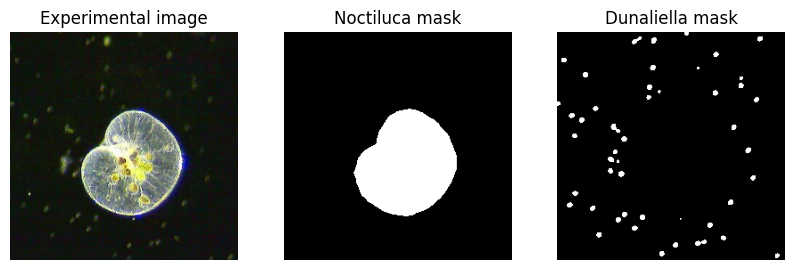

In [69]:
input = cropped_image[None, None, :, :]
# input = exp_image[None, None, :, :]
input = np.array(input.to_numpy(), dtype=np.float32)
with torch.no_grad():
    output = model(torch.from_numpy(input).float().to(device))

output = torch.softmax(output, dim=1)
output = output.cpu().numpy()
output.shape
# %%
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Experimental image")
plt.imshow(original_image.astype(np.uint8))
plt.axis("off")
plt.subplot(1, 3, 2)
plt.title("Noctiluca mask")
plt.imshow(output[0, 1, :, :] > 0.5, cmap="gray")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.title("Dunaliella mask")
plt.imshow(output[0, 2, :, :] > 0.5, cmap="gray")
plt.axis("off")
plt.show()

Overlay the segmentation masks on the experimental image

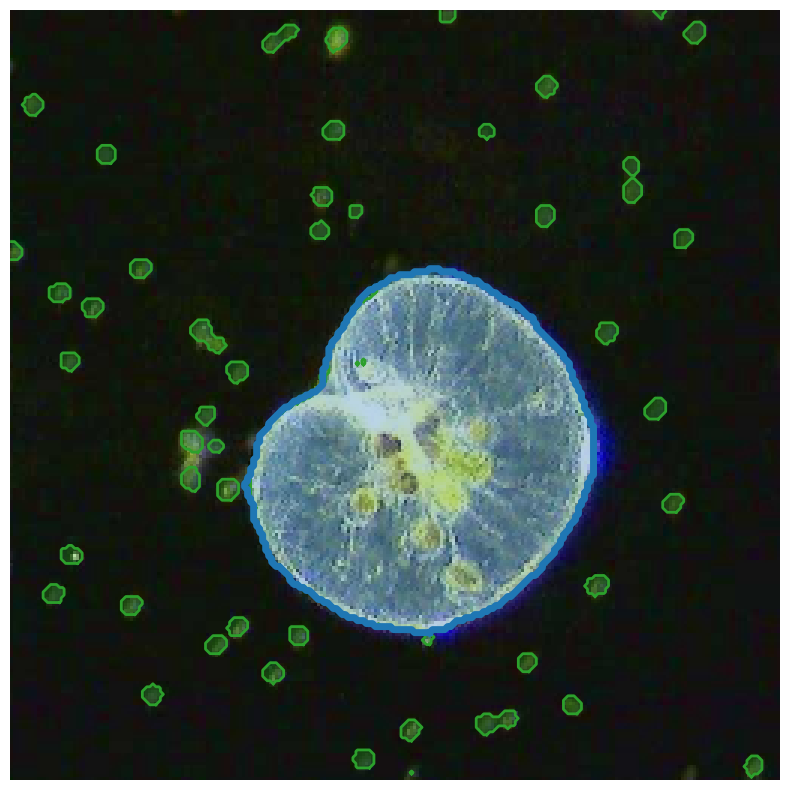

In [134]:
from skimage.measure import find_contours

contour1 = find_contours(output[0, 1, :, :] > 0.5, 0.5)
contour2 = find_contours(output[0, 2, :, :] > 0.1, 0.5)

fig = plt.figure(figsize=(10, 10))

plt.imshow(original_image.astype(np.uint8))

for contour in contour2:
    plt.plot(contour[:, 1], contour[:, 0], "C2", linewidth=2)
    plt.fill(contour[:, 1], contour[:, 0], "C2", alpha=0.3)

for contour in contour1:
    plt.plot(contour[:, 1], contour[:, 0], "C0", linewidth=5)
    plt.fill(contour[:, 1], contour[:, 0], "C0", alpha=0.3)

plt.axis("off")

# fig.savefig(
#     "../data/noctiluca-data/noctiluca_exp_image_segmented.jpg",
#     bbox_inches="tight",
#     pad_inches=0,
#     dpi=100,
# )

As you can see in the above image, the U-Net model, which is trained on simulated images, is able to predict the segmentation masks of the two species in the experimental image.

### 3.5. Detect the cells
In the next cell, we will try to detect the cells from the segmentation masks, and predict the number of cells belonging to each species.

In [19]:
from typing import List
from scipy import ndimage
from skimage.measure import regionprops

def detect_blobs_area(img_thresholded: np.ndarray, min_area: int) -> List[tuple]:
    # Find binary blobs
    img_copy = img_thresholded.copy()
    blobs, num_blobs = ndimage.label(img_copy)

    # Filter by area
    blobs_positions = []
    for i in range(1, num_blobs + 1):
        props = regionprops(blobs, intensity_image=None, cache=True)
        if props[i - 1].area < min_area:
            img_copy[blobs == i] = False
        else:
            blobs_positions.append(props[i - 1].centroid)
    return blobs_positions

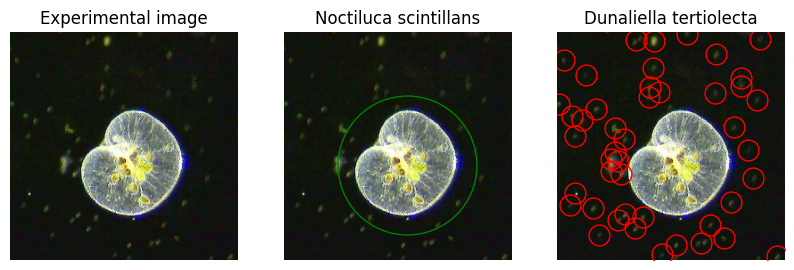

In [29]:
positions_noctiluca = detect_blobs_area(output[0, 1, :, :] > 0.5, min_area=10)
positions_dunaliella = detect_blobs_area(output[0, 2, :, :] > 0.5, min_area=10)

fig = plt.figure(figsize=(10, 30))
plt.subplot(1, 3, 1)
plt.title("Experimental image")
plt.imshow(original_image.astype(np.uint8))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Noctiluca scintillans")
plt.imshow(original_image.astype(np.uint8))
[
    plt.plot(
        p[1],
        p[0],
        "o",
        ms=100,
        markerfacecolor="None",
        markeredgecolor="green",
        markeredgewidth=1,
        alpha=1,
    )
    for p in positions_noctiluca
]
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Dunaliella tertiolecta")
plt.imshow(original_image.astype(np.uint8))
[
    plt.plot(
        p[1],
        p[0],
        "o",
        ms=15,
        markerfacecolor="None",
        markeredgecolor="red",
        markeredgewidth=1,
        alpha=1,
    )
    for p in positions_dunaliella
]
plt.axis("off")
plt.show()
# plt.savefig(
#     "../assets/display_fig.png",
#     dpi=300,
#     bbox_inches="tight",
# )
